<a href="https://colab.research.google.com/github/alinjomaa/C.Elegan_segmentation_ML_models/blob/main/finetuned_sam3_C_elegans_refined_multi_pass_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-Tuned SAM 3 Model for Worm Segmentation via Point Prompts

In this notebook, I fine-tuned Meta's SAM 3 model on a custom dataset of *C. elegans* worms. When comparing inference results between the Detectron2 Mask R-CNN model and SAM 3, I found that SAM 3 achieved significantly greater accuracy in segmenting touching and overlapping worms. The primary limitation of using SAM 3 is its requirement for prompting.

## Initialize

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies
!pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

# Clone and install SAM3
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e .

# Install Hugging Face hub for model download
!pip install huggingface_hub

Looking in indexes: https://download.pytorch.org/whl/cu126
fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15367 sha256=a359dbe299e3b8c7a0da5004b720c2b8dee6c90c0dda3b39656f08d87571e7f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgvhzgej/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [69]:
from huggingface_hub import login
login()

In [70]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 93.6 MB/s eta 0:00:00


In [ ]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, ConcatDataset
from pycocotools import mask as mask_utils


class WormDataset(Dataset):
    """A PyTorch Dataset for loading worm segmentation data in COCO format."""
    def __init__(self, coco_annotations_path, image_directory):
        """
        Initializes the dataset with COCO annotations and image directory.

        Args:
            coco_annotations_path (str): Path to the COCO JSON annotation file.
            image_directory (str): Path to the directory containing images.
        """
        with open(coco_annotations_path, "r") as f:
            coco_dataset_data = json.load(f)

        self.image_directory = image_directory
        self.image_information = coco_dataset_data["images"]
        self.segmentation_annotations = coco_dataset_data["annotations"]

        self.image_id_to_annotations_map = {}
        for annotation_entry in self.segmentation_annotations:
            image_identifier = annotation_entry["image_id"]
            if image_identifier not in self.image_id_to_annotations_map:
                self.image_id_to_annotations_map[image_identifier] = []
            self.image_id_to_annotations_map[image_identifier].append(annotation_entry)

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_information)

    def _ann_to_mask(self, annotation_entry, height, width):
        """Converts a COCO annotation entry into a binary segmentation mask."""
        segmentation_info = annotation_entry.get("segmentation", None)
        if segmentation_info is None:
            return None

        if isinstance(segmentation_info, list):
            if len(segmentation_info) > 0 and isinstance(segmentation_info[0], (int, float)):
                segmentation_info = [segmentation_info]

            run_length_encodings = mask_utils.frPyObjects(segmentation_info, height, width)


            if isinstance(run_length_encodings, dict):
                run_length_encoding = run_length_encodings
            else:
                run_length_encoding = mask_utils.merge(run_length_encodings)

            segmentation_mask = mask_utils.decode(run_length_encoding)
            return segmentation_mask


        if isinstance(segmentation_info, dict):
            run_length_encoding = segmentation_info


            if isinstance(run_length_encoding.get("counts", None), list):
                run_length_encoding = mask_utils.frPyObjects(run_length_encoding, height, width)

            segmentation_mask = mask_utils.decode(run_length_encoding)
            return segmentation_mask

        return None

    def __getitem__(self, idx):
        """Retrieves an image, its segmentation masks, and corresponding center points by index."""
        image_metadata = self.image_information[idx]
        image_path = os.path.join(self.image_directory, image_metadata["file_name"])
        input_image = Image.open(image_path).convert("RGB")

        height = image_metadata.get("height", input_image.height)
        width = image_metadata.get("width", input_image.width)

        annotations_for_image = self.image_id_to_annotations_map.get(image_metadata["id"], [])

        segmentation_masks = []
        center_points = []

        for annotation_entry in annotations_for_image:
            segmentation_mask = self._ann_to_mask(annotation_entry, height, width)
            if segmentation_mask is None:
                continue


            if segmentation_mask.ndim == 3:
                segmentation_mask = segmentation_mask[:, :, 0]

            if segmentation_mask.sum() == 0:
                continue

            segmentation_masks.append(segmentation_mask.astype(np.uint8))

            y_coords, x_coords = np.where(segmentation_mask > 0)
            center_x = int(x_coords.mean())
            center_y = int(y_coords.mean())
            center_points.append([center_x, center_y])

        if len(segmentation_masks) == 0:
            segmentation_masks = np.zeros((1, height, width), dtype=np.uint8)
            center_points = []

        segmentation_masks = torch.from_numpy(np.stack(segmentation_masks)).float()

        if len(center_points) == 0:
            center_points = torch.zeros((0, 2), dtype=torch.float32)
        else:
            center_points = torch.tensor(center_points, dtype=torch.float32)

        return {
            "image": input_image,
            "masks": segmentation_masks,
            "points": center_points
        }


worm_dataset_1 = WormDataset(
    "/content/drive/MyDrive/worm_segmentation/annotations_cleaned.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train"
)

worm_dataset_2 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/images"
)

worm_dataset_3 = WormDataset(
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json",
    "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2"
)

train_dataset = ConcatDataset([worm_dataset_1, worm_dataset_2, worm_dataset_3])

print("Total training images:", len(train_dataset))
print("  - Dataset 1:", len(worm_dataset_1), "images")
print("  - Dataset 2:", len(worm_dataset_2), "images")
print("  - Dataset 3:", len(worm_dataset_3), "images")

Total training images: 1626
  - Dataset 1: 197 images
  - Dataset 2: 1000 images
  - Dataset 3: 429 images


##Train


The below training script trains the model on all the instances within a image per epoch

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import Sam3TrackerModel, Sam3TrackerProcessor


def custom_collate(data_batch):
    """Custom collate function for the DataLoader to handle variable-sized masks/points."""
    return {
        "image": [batch_item["image"] for batch_item in data_batch],
        "masks": [batch_item["masks"] for batch_item in data_batch],
        "points": [batch_item["points"] for batch_item in data_batch],
    }


def dice_loss_with_logits(predicted_logits, ground_truth_targets, eps=1e-6):
    """Calculates the Dice loss between predicted logits and ground truth targets."""
    predicted_probabilities = torch.sigmoid(predicted_logits)
    predicted_probabilities = predicted_probabilities.reshape(predicted_probabilities.shape[0], -1)
    ground_truth_targets = ground_truth_targets.reshape(ground_truth_targets.shape[0], -1)
    intersection = (predicted_probabilities * ground_truth_targets).sum(dim=1)
    denominator = predicted_probabilities.sum(dim=1) + ground_truth_targets.sum(dim=1)
    dice_coefficient = (2 * intersection + eps) / (denominator + eps)
    return (1 - dice_coefficient).mean()


def mean_iou_from_logits(predicted_logits, ground_truth_targets, thr=0.5, eps=1e-6):
    """Calculates the mean IoU (Intersection over Union) from predicted logits and ground truth."""
    predictions_binary = (torch.sigmoid(predicted_logits) > thr).float()
    predictions_binary = predictions_binary.reshape(predictions_binary.shape[0], -1)
    ground_truth_targets = ground_truth_targets.reshape(ground_truth_targets.shape[0], -1)
    intersection = (predictions_binary * ground_truth_targets).sum(dim=1)
    union = predictions_binary.sum(dim=1) + ground_truth_targets.sum(dim=1) - intersection
    iou_score = (intersection + eps) / (union + eps)
    return iou_score.mean().item()


def get_all_instances(all_masks, all_points):
    """Returns all instances as a list of (mask, point) tuples."""
    if all_masks.ndim == 2:
        all_masks = all_masks.unsqueeze(0)

    num_instances = all_masks.shape[0]
    if num_instances == 0:
        return []

    instances = []
    for i in range(num_instances):
        mask_i = all_masks[i].unsqueeze(0)

        point_i = None
        if torch.is_tensor(all_points) and all_points.ndim == 2 and all_points.shape[0] == num_instances:
            point_i = all_points[i].unsqueeze(0)

        instances.append((mask_i, point_i))

    return instances


def point_from_single_mask(input_single_mask):
    """Computes the center point of a single segmentation mask."""
    if input_single_mask.ndim == 3:
        processed_mask = input_single_mask[0]
    else:
        processed_mask = input_single_mask

    y_coords, x_coords = torch.where(processed_mask > 0.5)
    if y_coords.numel() > 0:
        center_y = int(torch.mean(y_coords.float()).item())
        center_x = int(torch.mean(x_coords.float()).item())
        return torch.tensor([[center_x, center_y]], dtype=torch.float32)

    mask_height = processed_mask.shape[-2]
    mask_width = processed_mask.shape[-1]
    return torch.tensor([[mask_width // 2, mask_height // 2]], dtype=torch.float32)


def get_pred_logits(model_outputs):
    """Extracts and preprocesses predicted mask logits from model outputs."""
    raw_predicted_logits = model_outputs.pred_masks

    while raw_predicted_logits.ndim > 3:
        if raw_predicted_logits.shape[0] == 1:
            raw_predicted_logits = raw_predicted_logits.squeeze(0)
        else:
            raw_predicted_logits = raw_predicted_logits[0]
            break

    if raw_predicted_logits.ndim == 3:
        raw_predicted_logits = raw_predicted_logits[0].unsqueeze(0)

    if raw_predicted_logits.ndim == 2:
        raw_predicted_logits = raw_predicted_logits.unsqueeze(0)

    return raw_predicted_logits


def align_gt_to_pred(predicted_logits, ground_truth_mask):
    """Resizes the ground truth mask to match the dimensions of the predicted logits."""
    if ground_truth_mask.ndim == 2:
        ground_truth_mask = ground_truth_mask.unsqueeze(0)
    ground_truth_mask = ground_truth_mask.float()

    if predicted_logits.shape[-2:] != ground_truth_mask.shape[-2:]:
        ground_truth_mask = F.interpolate(
            ground_truth_mask.unsqueeze(1),
            size=predicted_logits.shape[-2:],
            mode="bilinear",
            align_corners=False
        ).squeeze(1)

    if predicted_logits.shape != ground_truth_mask.shape:
        raise ValueError("Shape mismatch pred " + str(tuple(predicted_logits.shape)) + " vs gt " + str(tuple(ground_truth_mask.shape)))

    return ground_truth_mask


def train_sam3(
    training_dataset,
    number_of_epochs=20,
    training_batch_size=1,
    learning_rate=1e-4,
    optimizer_weight_decay=0.01,
    gradient_accumulation_steps=4,
    use_automatic_mixed_precision=True,
    checkpoint_save_directory="/content/drive/MyDrive/sam3_worm_checkpoints",
):
    """Trains the SAM3 model for worm segmentation using point prompts."""
    os.makedirs(checkpoint_save_directory, exist_ok=True)

    computation_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    is_cuda_available = (computation_device.type == "cuda")

    sam3_model = Sam3TrackerModel.from_pretrained("facebook/sam3")
    sam3_processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

    for param_name, parameter in sam3_model.named_parameters():
        if "vision_encoder" in param_name or "image_encoder" in param_name:
            parameter.requires_grad = False
        else:
            parameter.requires_grad = True

    trainable_parameters = [p for p in sam3_model.parameters() if p.requires_grad]
    if len(trainable_parameters) == 0:
        for p in sam3_model.parameters():
            p.requires_grad = True
        trainable_parameters = list(sam3_model.parameters())

    sam3_model.to(computation_device)
    sam3_model.train()

    model_optimizer = torch.optim.AdamW(trainable_parameters, lr=learning_rate, weight_decay=optimizer_weight_decay)
    gradient_scaler = torch.cuda.amp.GradScaler(enabled=(use_automatic_mixed_precision and is_cuda_available))

    training_data_loader = DataLoader(
        training_dataset,
        batch_size=training_batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )

    total_training_steps = 0
    current_accumulation_steps = 0

    for current_epoch in range(number_of_epochs):
        total_epoch_loss = 0.0
        total_epoch_iou = 0.0

        total_examples_processed = 0
        successful_examples = 0
        auto_generated_points_count = 0
        failed_examples = 0
        skipped_examples = 0

        model_optimizer.zero_grad(set_to_none=True)

        progress_bar = tqdm(training_data_loader, desc="Epoch " + str(current_epoch + 1) + "/" + str(number_of_epochs))

        for data_batch in progress_bar:
            for batch_index in range(len(data_batch["image"])):

                input_image = data_batch["image"][batch_index]
                ground_truth_masks = data_batch["masks"][batch_index].to(computation_device)
                ground_truth_points = data_batch["points"][batch_index]

                instances = get_all_instances(ground_truth_masks, ground_truth_points)

                if len(instances) == 0:
                    skipped_examples += 1
                    continue

                try:
                    image_inputs = sam3_processor(images=input_image, return_tensors="pt").to(computation_device)
                    with torch.no_grad():
                        image_embeddings = sam3_model.get_image_embeddings(image_inputs["pixel_values"])
                except Exception as e:
                    skipped_examples += 1
                    print("Failed to encode image:", str(e))
                    continue

                for (selected_ground_truth_mask, selected_point_prompt) in instances:
                    total_examples_processed += 1

                    try:
                        if selected_point_prompt is None or (torch.is_tensor(selected_point_prompt) and selected_point_prompt.numel() == 0):
                            selected_point_prompt = point_from_single_mask(selected_ground_truth_mask.detach())
                            auto_generated_points_count += 1

                        if not torch.is_tensor(selected_point_prompt):
                            selected_point_prompt = torch.tensor(selected_point_prompt, dtype=torch.float32)

                        processor_input_points = [[selected_point_prompt.detach().cpu().tolist()]]
                        processor_input_labels = [[[1] * selected_point_prompt.shape[0]]]


                        processed_inputs = sam3_processor(
                            images=input_image,
                            input_points=processor_input_points,
                            input_labels=processor_input_labels,
                            return_tensors="pt"
                        )
                        processed_inputs = processed_inputs.to(computation_device)
                        processed_inputs.pop("pixel_values", None)
                        if use_automatic_mixed_precision and is_cuda_available:
                            with torch.cuda.amp.autocast():
                                model_outputs = sam3_model(image_embeddings=image_embeddings, **processed_inputs, multimask_output=False)
                                predicted_mask_logits = get_pred_logits(model_outputs)
                                aligned_ground_truth_mask = align_gt_to_pred(predicted_mask_logits, selected_ground_truth_mask)
                                current_loss = F.binary_cross_entropy_with_logits(predicted_mask_logits, aligned_ground_truth_mask) + dice_loss_with_logits(predicted_mask_logits, aligned_ground_truth_mask)
                                current_loss = current_loss / gradient_accumulation_steps
                        else:
                            model_outputs = sam3_model(image_embeddings=image_embeddings, **processed_inputs, multimask_output=False)
                            predicted_mask_logits = get_pred_logits(model_outputs)
                            aligned_ground_truth_mask = align_gt_to_pred(predicted_mask_logits, selected_ground_truth_mask)
                            current_loss = F.binary_cross_entropy_with_logits(predicted_mask_logits, aligned_ground_truth_mask) + dice_loss_with_logits(predicted_mask_logits, aligned_ground_truth_mask)
                            current_loss = current_loss / gradient_accumulation_steps

                        if gradient_scaler.is_enabled():
                            gradient_scaler.scale(current_loss).backward()
                        else:
                            current_loss.backward()

                        current_accumulation_steps += 1

                        if current_accumulation_steps >= gradient_accumulation_steps:
                            if gradient_scaler.is_enabled():
                                gradient_scaler.unscale_(model_optimizer)

                            torch.nn.utils.clip_grad_norm_(trainable_parameters, 1.0)

                            if gradient_scaler.is_enabled():
                                gradient_scaler.step(model_optimizer)
                                gradient_scaler.update()
                            else:
                                model_optimizer.step()

                            model_optimizer.zero_grad(set_to_none=True)
                            current_accumulation_steps = 0

                        successful_examples += 1
                        total_training_steps += 1

                        total_epoch_loss += current_loss.item() * gradient_accumulation_steps
                        total_epoch_iou += mean_iou_from_logits(predicted_mask_logits.detach(), aligned_ground_truth_mask.detach())

                        average_epoch_loss = total_epoch_loss / max(1, successful_examples)
                        average_epoch_iou = total_epoch_iou / max(1, successful_examples)

                        progress_bar.set_postfix({
                            "Loss": f"{(current_loss.item() * gradient_accumulation_steps):.4f}",
                            "Avg": f"{average_epoch_loss:.4f}",
                            "IoU": f"{average_epoch_iou:.3f}",
                            "Success": str(successful_examples) + "/" + str(total_examples_processed),
                            "AutoPts": auto_generated_points_count,
                            "Skip": skipped_examples,
                            "Fail": failed_examples
                        })



                    except Exception as e:
                        failed_examples += 1
                        if failed_examples <= 5:
                            print("\nFAILED example:", str(e))
                            try:
                                print("masks shape:", tuple(ground_truth_masks.shape))
                            except:
                                pass
                        continue

        if current_accumulation_steps > 0:
            if gradient_scaler.is_enabled():
                gradient_scaler.unscale_(model_optimizer)

            torch.nn.utils.clip_grad_norm_(trainable_parameters, 1.0)

            if gradient_scaler.is_enabled():
                gradient_scaler.step(model_optimizer)
                gradient_scaler.update()
            else:
                model_optimizer.step()

            model_optimizer.zero_grad(set_to_none=True)
            current_accumulation_steps = 0

        checkpoint_path = os.path.join(checkpoint_save_directory, "epoch_" + str(current_epoch + 1))
        os.makedirs(checkpoint_path, exist_ok=True)
        sam3_model.save_pretrained(checkpoint_path)

        print("\nEpoch", current_epoch + 1, "done")
        print("Avg loss:", total_epoch_loss / max(1, successful_examples))
        print("Avg IoU :", total_epoch_iou / max(1, successful_examples))
        print("Success:", str(successful_examples) + "/" + str(total_examples_processed))
        print("Auto points:", auto_generated_points_count, "| Skipped:", skipped_examples, "| Failed:", failed_examples)


train_sam3(train_dataset, number_of_epochs=20, training_batch_size=1, gradient_accumulation_steps=4, use_automatic_mixed_precision=True)

You are using a model of type sam3_video to instantiate a model of type sam3_tracker. This is not supported for all configurations of models and can yield errors.


Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

/tmp/ipython-input-1302005414.py:156: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  gradient_scaler = torch.cuda.amp.GradScaler(enabled=(use_automatic_mixed_precision and is_cuda_available))
Epoch 1/20:   0%|          | 0/1626 [00:00<?, ?it/s]/tmp/ipython-input-1302005414.py:231: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20:  97%|█████████▋| 1575/1626 [49:43<01:40,  1.97s/it, Loss=0.0729, Avg=0.2202, IoU=0.707, Success=25070/25070, AutoPts=0, Skip=0, Fail=0]/tmp/ipython-input-1302005414.py:231: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 1626/1626 [51:18<00:00,  1.89s/it, Loss=0.1201, Avg=0.2195, IoU=0.708, Success=25904/25904, AutoPts=0, Skip=

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 1 done
Avg loss: 0.21945599895774562
Avg IoU : 0.7080588167637524
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 2/20: 100%|██████████| 1626/1626 [33:42<00:00,  1.24s/it, Loss=0.1381, Avg=0.1772, IoU=0.755, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 2 done
Avg loss: 0.1771960840561934
Avg IoU : 0.7545612369412745
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 3/20: 100%|██████████| 1626/1626 [33:45<00:00,  1.25s/it, Loss=0.1917, Avg=0.1603, IoU=0.774, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 3 done
Avg loss: 0.16025058586249494
Avg IoU : 0.773542865871472
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 4/20: 100%|██████████| 1626/1626 [33:40<00:00,  1.24s/it, Loss=0.0429, Avg=0.1481, IoU=0.787, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 4 done
Avg loss: 0.14809936653168893
Avg IoU : 0.7873167479537959
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 5/20: 100%|██████████| 1626/1626 [33:40<00:00,  1.24s/it, Loss=0.0459, Avg=0.1424, IoU=0.794, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 5 done
Avg loss: 0.14239056984021187
Avg IoU : 0.7944224007081909
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 6/20: 100%|██████████| 1626/1626 [33:46<00:00,  1.25s/it, Loss=0.1125, Avg=0.1335, IoU=0.804, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 6 done
Avg loss: 0.13348870971184018
Avg IoU : 0.804396264996637
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 7/20: 100%|██████████| 1626/1626 [33:41<00:00,  1.24s/it, Loss=0.1681, Avg=0.1284, IoU=0.811, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 7 done
Avg loss: 0.12840332567258644
Avg IoU : 0.8105783317200264
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 8/20: 100%|██████████| 1626/1626 [33:51<00:00,  1.25s/it, Loss=0.0518, Avg=0.1250, IoU=0.815, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 8 done
Avg loss: 0.12501282368285738
Avg IoU : 0.8146531731659252
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 9/20: 100%|██████████| 1626/1626 [33:47<00:00,  1.25s/it, Loss=0.0872, Avg=0.1194, IoU=0.821, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 9 done
Avg loss: 0.11943128780795347
Avg IoU : 0.8213602219113904
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 10/20: 100%|██████████| 1626/1626 [33:47<00:00,  1.25s/it, Loss=0.0891, Avg=0.1167, IoU=0.825, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 10 done
Avg loss: 0.11672273008065118
Avg IoU : 0.8247764341745255
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 11/20: 100%|██████████| 1626/1626 [33:51<00:00,  1.25s/it, Loss=0.0643, Avg=0.1131, IoU=0.829, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 11 done
Avg loss: 0.11306698606739976
Avg IoU : 0.8290886870067722
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 12/20: 100%|██████████| 1626/1626 [33:21<00:00,  1.23s/it, Loss=0.0863, Avg=0.1109, IoU=0.832, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 12 done
Avg loss: 0.11088693434499962
Avg IoU : 0.8317398692505742
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 13/20: 100%|██████████| 1626/1626 [33:28<00:00,  1.24s/it, Loss=0.1039, Avg=0.1091, IoU=0.834, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 13 done
Avg loss: 0.10913323872545654
Avg IoU : 0.8341424433985939
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 14/20: 100%|██████████| 1626/1626 [33:38<00:00,  1.24s/it, Loss=0.0382, Avg=0.1062, IoU=0.838, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 14 done
Avg loss: 0.10618428992560301
Avg IoU : 0.8377279092141137
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 15/20: 100%|██████████| 1626/1626 [33:29<00:00,  1.24s/it, Loss=0.0798, Avg=0.1044, IoU=0.840, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 15 done
Avg loss: 0.1044185830337278
Avg IoU : 0.8398296217879219
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 16/20: 100%|██████████| 1626/1626 [33:30<00:00,  1.24s/it, Loss=0.0579, Avg=0.1025, IoU=0.842, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 16 done
Avg loss: 0.10254473791210644
Avg IoU : 0.8421799259195957
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 17/20: 100%|██████████| 1626/1626 [33:31<00:00,  1.24s/it, Loss=0.0359, Avg=0.1006, IoU=0.845, Success=25904/25904, AutoPts=0, Skip=0, Fail=0]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 17 done
Avg loss: 0.10062158510637992
Avg IoU : 0.844970819119131
Success: 25904/25904
Auto points: 0 | Skipped: 0 | Failed: 0


Epoch 18/20:  46%|████▌     | 751/1626 [15:26<17:59,  1.23s/it, Loss=0.0469, Avg=0.0984, IoU=0.848, Success=12062/12062, AutoPts=0, Skip=0, Fail=0]


KeyboardInterrupt: 

#Inference

In [71]:
import base64
from io import BytesIO
from PIL import Image

OBJECTS = ['worm']

def encode_image_pillow(image: Image.Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    encoded = base64.b64encode(image_bytes).decode("utf-8")
    return "data:image/jpeg;base64," + encoded

In [ ]:
import numpy as np

def get_normalized_boxes(bboxes, label, resolution_wh):
    width, height = resolution_wh
    boxes = [
        [b["x"] + b["width"] / 2, b["y"] + b["height"] / 2, b["width"], b["height"]]
        for b in bboxes
        if b["label"] == label
    ]
    if not boxes:
        return np.empty((0, 4), dtype=np.float32)
    scale = np.array([width, height, width, height], dtype=np.float32).reshape(1,-1)
    return np.array(boxes, dtype=np.float32) / scale

In [ ]:
!pip install jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.7 MB/s eta 0:00:00


In [77]:
from PIL import Image
from jupyter_bbox_widget import BBoxWidget

image_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/val/Imaging_cat-2_fmo-2MC_DR_ch01.jpg"
image = Image.open(image_path).convert("RGB")

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image_pillow(image)
widget

Morphological closing + Gaussian Blur

Loading weights:   0%|          | 0/685 [00:00<?, ?it/s]

Derived 21 points from bounding boxes. Performing inference...


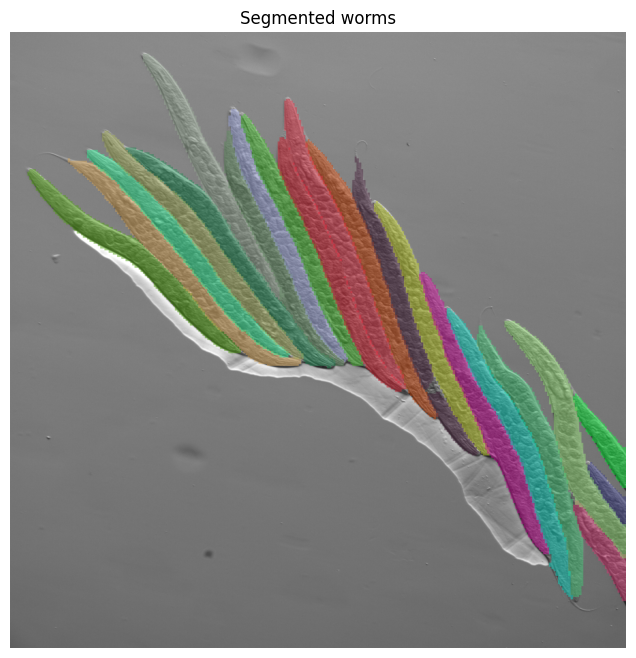

Successfully segmented 21 objects.
Saved masks to: /content/worm_segmentation_masks.npy with shape (21, 1024, 1024)


In [91]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import Sam3TrackerModel, Sam3TrackerProcessor
import shutil
import os
from PIL import Image
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"

model_save_dir = "/content/drive/MyDrive/sam3_worm_checkpoints"
model_checkpoint_name = "epoch_14"

model_path_on_drive = os.path.join(model_save_dir, model_checkpoint_name)
local_model_path = os.path.join("/content", model_checkpoint_name)

if not os.path.exists(local_model_path):
    print(f"Copying model from drive: {model_path_on_drive} to {local_model_path}")
    try:
        shutil.copytree(model_path_on_drive, local_model_path)
        print("Model copied successfully.")
    except Exception as e:
        print(f"Error copying model: {e}")
        print("Please ensure the model path exists and is accessible.")
        raise

needed_files = ["config.json", "model.safetensors"]
missing_files = []
for filename in needed_files:
    full_path = os.path.join(local_model_path, filename)
    if not os.path.exists(full_path):
        missing_files.append(filename)

if missing_files:
    raise FileNotFoundError(f"Missing in {local_model_path}: {missing_files}")

model = Sam3TrackerModel.from_pretrained(local_model_path).to(device)
model.eval()

processor = Sam3TrackerProcessor.from_pretrained("/content/drive/MyDrive/sam3_processor")

bbox_annotations = widget.bboxes

input_points_for_processor = []
input_labels_for_processor = []

if bbox_annotations:
    current_image_points = []
    current_image_labels = []

    for bbox_info in bbox_annotations:
        x_min = bbox_info["x"]
        y_min = bbox_info["y"]
        width = bbox_info["width"]
        height = bbox_info["height"]

        center_x = x_min + (width / 2)
        center_y = y_min + (height / 2)

        current_image_points.append([[center_x, center_y]])
        current_image_labels.append([1])

    input_points_for_processor.append(current_image_points)
    input_labels_for_processor.append(current_image_labels)

if (not input_points_for_processor) or (len(input_points_for_processor[0]) == 0):
    print("No points derived from bounding boxes for segmentation.")
else:
    num_derived_points = len(input_points_for_processor[0])
    print(f"Derived {num_derived_points} points from bounding boxes. Performing inference...")

    overlay = np.array(image).astype(np.float32)
    all_masks = []

    inputs = processor(
        images=image,
        input_points=input_points_for_processor,
        input_labels=input_labels_for_processor,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    pred_masks = outputs.pred_masks

    if pred_masks.ndim == 5:
        pred_masks = pred_masks[:, :, 0, :, :]

    if pred_masks.ndim != 4:
        raise ValueError(f"Unexpected pred_masks shape: {tuple(outputs.pred_masks.shape)}")

    num_objects = pred_masks.shape[1]
    h, w = overlay.shape[0], overlay.shape[1]

    # collect all sigmoid probability maps
    all_probs = []
    for i in range(num_objects):
        prob = torch.sigmoid(pred_masks[0, i, :, :]).cpu().numpy()
        all_probs.append(prob)

    prob_stack = np.stack(all_probs, axis=0)  # (num_objects, H, W)

    winner = np.argmax(prob_stack, axis=0)
    max_prob = np.max(prob_stack, axis=0)

    alpha = 0.5

    for i in range(num_objects):
        # Winner-takes-all threshold
        mask = ((winner == i) & (max_prob > 0.60)).astype(np.uint8)

        # Step 1: morphological close, fills holes and recovers tip pixels
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_large)

        # Step 2: Gaussian blur + re-threshold — smooths edges naturally
        # kernel size (7,7): larger = smoother. Must be odd number e.g. 5,7,9,11
        # re-threshold 0.5: higher = tighter after blur, lower = more inclusive
        blurred = cv2.GaussianBlur(mask.astype(np.float32), (7, 7), 0)
        mask = (blurred > 0.4).astype(np.uint8)

        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        all_masks.append(mask)

        color = np.random.uniform(0, 255, size=(3,))
        overlay[mask == 1] = overlay[mask == 1] * (1 - alpha) + color * alpha

    plt.figure(figsize=(10, 8))
    plt.imshow(overlay.astype(np.uint8))
    plt.axis("off")
    plt.title("Segmented worms")
    plt.show()

    masks_array = np.stack(all_masks, axis=0)
    output_filename = "/content/worm_segmentation_masks.npy"
    np.save(output_filename, masks_array)

    print(f"Successfully segmented {len(all_masks)} objects.")
    print(f"Saved masks to: {output_filename} with shape {masks_array.shape}")

The cell below takes the masks from the original inferneces, uses those predicted masks as prompts and refines the predicted masks

Running SAM3 refinement pass...


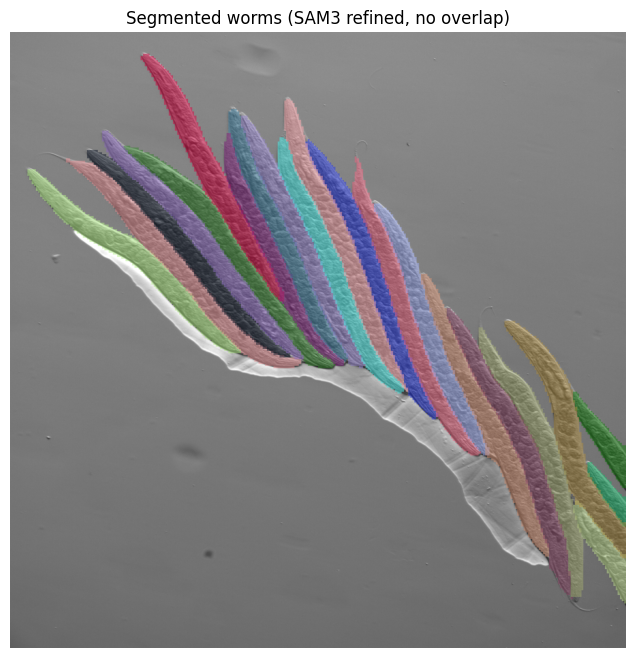

Refinement complete. 21 valid masks.
Saved to: /content/worm_segmentation_masks_refined.npy with shape (21, 1024, 1024)


In [94]:
#  SAM3 Refinement Pass
print("Running SAM3 refinement pass...")

refined_overlay = np.array(image).astype(np.float32)
refined_masks = []

# First collect ALL refined logits before thresholding
all_refined_probs = []

for i in range(num_objects):
    rough_mask = all_masks[i]

    if rough_mask.sum() == 0:
        # dead mask — push zeros so indexing stays consistent
        all_refined_probs.append(np.zeros((pred_masks.shape[-2], pred_masks.shape[-1])))
        continue

    mask_for_prompt = cv2.resize(rough_mask,
                                  (pred_masks.shape[-1], pred_masks.shape[-2]),
                                  interpolation=cv2.INTER_NEAREST)

    mask_prompt = torch.tensor(mask_for_prompt).unsqueeze(0).unsqueeze(0).float().to(device)

    single_point = [[input_points_for_processor[0][i]]]
    single_label = [[input_labels_for_processor[0][i]]]

    try:
        inputs_refine = processor(
            images=image,
            input_points=single_point,
            input_labels=single_label,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs_refine = model(
                **inputs_refine,
                input_masks=mask_prompt,
                multimask_output=False
            )

        refined_pred = outputs_refine.pred_masks
        if refined_pred.ndim == 5:
            refined_pred = refined_pred[:, :, 0, :, :]

        prob = torch.sigmoid(refined_pred[0, 0, :, :]).cpu().numpy()
        all_refined_probs.append(prob)

    except Exception as e:
        print(f"Refinement failed for object {i}, using original prob. Error: {e}")
        # Fall back to original probability map
        all_refined_probs.append(all_probs[i])

# Re-apply winner-takes-all across all refined probability maps
refined_prob_stack = np.stack(all_refined_probs, axis=0)
refined_winner = np.argmax(refined_prob_stack, axis=0)
refined_max_prob = np.max(refined_prob_stack, axis=0)

for i in range(num_objects):
    refined_mask = ((refined_winner == i) & (refined_max_prob > 0.60)).astype(np.uint8)

    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel_large)
    blurred = cv2.GaussianBlur(refined_mask.astype(np.float32), (7, 7), 0)
    refined_mask = (blurred > 0.4).astype(np.uint8)

    refined_mask = cv2.resize(refined_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    refined_masks.append(refined_mask)

    color = np.random.uniform(0, 255, size=(3,))
    refined_overlay[refined_mask == 1] = (
        refined_overlay[refined_mask == 1] * (1 - alpha) + color * alpha
    )

plt.figure(figsize=(10, 8))
plt.imshow(refined_overlay.astype(np.uint8))
plt.axis("off")
plt.title("Segmented worms (SAM3 refined, no overlap)")
plt.show()

refined_masks_array = np.stack(refined_masks, axis=0)
refined_output_filename = "/content/worm_segmentation_masks_refined.npy"
np.save(refined_output_filename, refined_masks_array)

print(f"Refinement complete. {len([m for m in refined_masks if m.sum() > 0])} valid masks.")
print(f"Saved to: {refined_output_filename} with shape {refined_masks_array.shape}")

If needed, possible 2nd refinement pass

Running SAM3 second refinement pass...


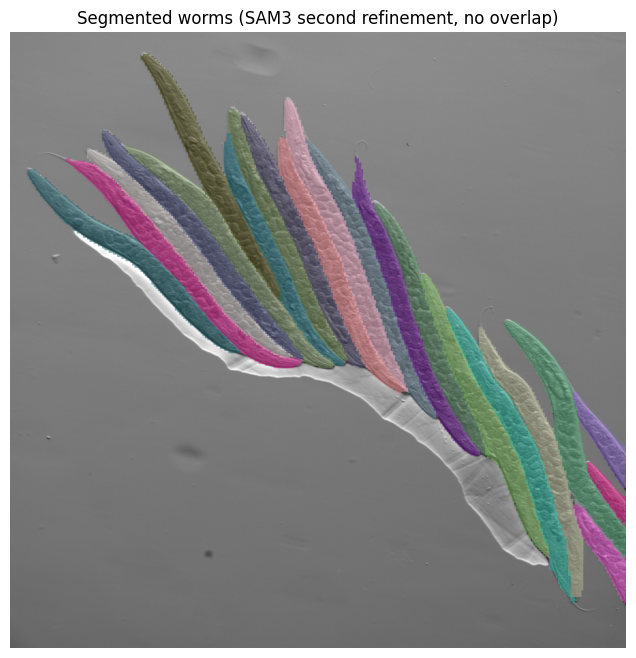

Second refinement complete. 21 valid masks.
Saved to: /content/worm_segmentation_masks_refined_2.npy with shape (21, 1024, 1024)


In [95]:
# SAM3 Second Refinement Pass
print("Running SAM3 second refinement pass...")

refined_overlay_2 = np.array(image).astype(np.float32)
refined_masks_2 = []

# Collect ALL refined logits before thresholding
all_refined_probs_2 = []

for i in range(num_objects):
    rough_mask = refined_masks[i]  # feed from Cell 2 output

    if rough_mask.sum() == 0:
        all_refined_probs_2.append(np.zeros((pred_masks.shape[-2], pred_masks.shape[-1])))
        continue

    mask_for_prompt = cv2.resize(rough_mask,
                                  (pred_masks.shape[-1], pred_masks.shape[-2]),
                                  interpolation=cv2.INTER_NEAREST)

    mask_prompt = torch.tensor(mask_for_prompt).unsqueeze(0).unsqueeze(0).float().to(device)

    single_point = [[input_points_for_processor[0][i]]]
    single_label = [[input_labels_for_processor[0][i]]]

    try:
        inputs_refine = processor(
            images=image,
            input_points=single_point,
            input_labels=single_label,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs_refine = model(
                **inputs_refine,
                input_masks=mask_prompt,
                multimask_output=False
            )

        refined_pred = outputs_refine.pred_masks
        if refined_pred.ndim == 5:
            refined_pred = refined_pred[:, :, 0, :, :]

        prob = torch.sigmoid(refined_pred[0, 0, :, :]).cpu().numpy()
        all_refined_probs_2.append(prob)

    except Exception as e:
        print(f"Refinement failed for object {i}, using previous prob. Error: {e}")
        all_refined_probs_2.append(all_refined_probs[i])  # fall back to Cell 2 probs

# Re-apply winner-takes-all across all refined probability maps
refined_prob_stack_2 = np.stack(all_refined_probs_2, axis=0)
refined_winner_2 = np.argmax(refined_prob_stack_2, axis=0)
refined_max_prob_2 = np.max(refined_prob_stack_2, axis=0)

for i in range(num_objects):
    refined_mask = ((refined_winner_2 == i) & (refined_max_prob_2 > 0.60)).astype(np.uint8)

    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel_large)
    blurred = cv2.GaussianBlur(refined_mask.astype(np.float32), (7, 7), 0)
    refined_mask = (blurred > 0.4).astype(np.uint8)

    refined_mask = cv2.resize(refined_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    refined_masks_2.append(refined_mask)

    color = np.random.uniform(0, 255, size=(3,))
    refined_overlay_2[refined_mask == 1] = (
        refined_overlay_2[refined_mask == 1] * (1 - alpha) + color * alpha
    )

plt.figure(figsize=(10, 8))
plt.imshow(refined_overlay_2.astype(np.uint8))
plt.axis("off")
plt.title("Segmented worms (SAM3 second refinement, no overlap)")
plt.show()

refined_masks_array_2 = np.stack(refined_masks_2, axis=0)
refined_output_filename_2 = "/content/worm_segmentation_masks_refined_2.npy"
np.save(refined_output_filename_2, refined_masks_array_2)

print(f"Second refinement complete. {len([m for m in refined_masks_2 if m.sum() > 0])} valid masks.")
print(f"Saved to: {refined_output_filename_2} with shape {refined_masks_array_2.shape}")